In [42]:
import pandas as pd
import numpy as np
from tkinter import filedialog as fd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import butter,filtfilt
from scipy.interpolate import CubicSpline


In [43]:
def square(list):
    return [i ** 2 for i in list]

In [44]:
sampling_freq = 50
sampling_interval = 1/sampling_freq;
upsample_rate = 20 #amount by which to upsample data to improve peak resolution


In [45]:
# Filter requirements.
T = 60        # Sample Period
fs = 1/sampling_interval       # sample rate, Hz
cutoff = 12     # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 3 #filter order


In [46]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [47]:
filename = fd.askopenfilename()

In [48]:
seconds_to_discard = 6; #number of beats to throw out during normalization portion at start of dataset
df = pd.read_csv(filename)
dataset = df.iloc[seconds_to_discard*sampling_freq:3000,0]*(-1) #inverting the signal to support subsequent peak-finding process


In [49]:
dataset

300     -12.00
301     -12.04
302     -12.08
303     -12.12
304     -12.16
         ...  
2995   -119.80
2996   -119.84
2997   -119.88
2998   -119.92
2999   -119.96
Name: Time, Length: 2700, dtype: float64

In [50]:
time = np.arange(seconds_to_discard,len(dataset)*sampling_interval+seconds_to_discard,sampling_interval)

In [51]:
cs = CubicSpline(time,dataset)
time_cs = np.arange(seconds_to_discard,len(dataset)*sampling_interval+seconds_to_discard,1/upsample_rate*sampling_interval)
data_cs = cs(time_cs) #cubic spline interpolation of existing data to allow increased peak resolution (better than sampling interval)

In [52]:
dataset_sma = butter_lowpass_filter(data_cs,cutoff,fs,order)

In [53]:
peaks,_ = find_peaks(dataset,height = 0.5,distance = 300)
print(peaks)

[]


In [54]:
ibi = list()
ibi_sd = list()

for x in np.arange(0,len(peaks)-1,1):
    ibi.append((peaks[x+1]-peaks[x])*sampling_interval/upsample_rate)

for x in np.arange(0,len(ibi)-1,1):
    ibi_sd.append(1000*(ibi[x+1]-ibi[x]))

In [55]:
ibi_sd_squared = square(ibi_sd)
n = len(ibi_sd_squared)

In [56]:
RMSSD = np.sqrt(np.mean(ibi_sd_squared))

/Users/lisajin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lisajin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
print(RMSSD)

nan


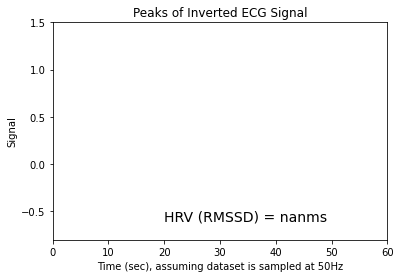

In [58]:
plt.plot(time_cs,dataset_sma,'dimgray')
plt.scatter(time_cs[peaks],dataset_sma[peaks],c="blueviolet",marker = 'o',linestyle = 'None')
plt.text(20,-0.6,"HRV (RMSSD) = " + str(round(RMSSD,1))+"ms",fontsize = 14)
plt.xlim([0,3000*sampling_interval])
plt.ylim([-0.8,1.5])
plt.title("Peaks of Inverted ECG Signal")
plt.xlabel("Time (sec), assuming dataset is sampled at 50Hz")
plt.ylabel("Signal")
plt.show()